# 신규 아파트 주차 수요 예측

# 데이터 전처리

## [미션]

단지별 등록 차량 수를 예측하기에 적합한 형태로 데이터 전처리를 수행합니다.

1) 필요한 변수를 추가하고 불필요한 변수를 제거합니다.
2) 단지별 데이터와 상세 데이터를 분리합니다.
3) 상세 데이터를 단지별로 집계합니다.
    - 단지별 총면적 집계
    - 전용면적구간 집계 (피벗형태)
    - 단지별 임대보증금, 임대료 평균 집계
4) 단지별 데이터와 집계 데이터를 하나로 합칩니다.
5) 변수 추가 (옵션)
    - 등록 차량수를 예측하기 위해 필요한 변수를 추가합니다.

## 1. 환경설정

In [7]:
# 기본 경로
path = ''

- 구글 콜랩을 사용중이면 구글 드라이브를 연결합니다.

In [9]:
# 구글 드라이브 연결, 패스 지정
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/project/'

### 라이브러리 불러오기

In [13]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

import joblib
import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format='retina'

### 데이터 불러오기

#### 1) 데이터 불러오기

In [16]:
# 파일 불러오기
apart = pd.read_excel(path+'train.xlsx')

#### 2) 기본 정보 조회

In [18]:
apart.tail(3)

,단지코드,단지명,총세대수,전용면적별세대수,지역,준공일자,건물형태,난방방식,승강기설치여부,단지내주차면수,전용면적,공용면적,임대보증금,임대료,실차량수
1154,C0358,화천신읍(공공실버) 영구임대,120,54,강원,20200110,복도식,NaN,전체동 설치,40,33.84,20.6553,2902000,57730,47
1155,C0359,영천야사4,447,149,대구경북,19940615,복도식,중앙유류난방,전체동 설치,89,26.37,13.3800,7134000,118880,78
1156,C0359,영천야사4,447,298,대구경북,19940615,복도식,중앙유류난방,전체동 설치,89,31.32,13.8500,8122000,131140,78


In [19]:
apart.head(3)

,단지코드,단지명,총세대수,전용면적별세대수,지역,준공일자,건물형태,난방방식,승강기설치여부,단지내주차면수,전용면적,공용면적,임대보증금,임대료,실차량수
0,C0001,엘에이치 서초4단지,78,35,서울,20131204,계단식,개별가스난방,전체동 설치,120,51.89,19.2603,50758000,620370,109
1,C0001,엘에이치 서초4단지,78,43,서울,20131204,계단식,개별가스난방,전체동 설치,120,59.93,22.2446,63166000,665490,109
2,C0002,LH삼성아파트,35,26,서울,20130801,복도식,개별가스난방,전체동 설치,47,27.75,16.5375,63062000,458640,35


In [20]:
apart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1157 entries, 0 to 1156
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   단지코드      1157 non-null   object 
 1   단지명       1157 non-null   object 
 2   총세대수      1157 non-null   int64  
 3   전용면적별세대수  1157 non-null   int64  
 4   지역        1157 non-null   object 
 5   준공일자      1157 non-null   int64  
 6   건물형태      1135 non-null   object 
 7   난방방식      1082 non-null   object 
 8   승강기설치여부   1059 non-null   object 
 9   단지내주차면수   1157 non-null   int64  
 10  전용면적      1157 non-null   float64
 11  공용면적      1157 non-null   float64
 12  임대보증금     1157 non-null   int64  
 13  임대료       1157 non-null   int64  
 14  실차량수      1157 non-null   int64  
dtypes: float64(2), int64(7), object(6)
memory usage: 135.7+ KB


In [21]:
apart.describe()

,총세대수,전용면적별세대수,준공일자,단지내주차면수,전용면적,공용면적,임대보증금,임대료,실차량수
count,1157.000000,1157.000000,1.157000e+03,1157.000000,1157.000000,1157.000000,1.157000e+03,1.157000e+03,1157.000000
mean,659.075194,163.691443,2.008667e+07,682.261884,51.565584,20.562360,2.850789e+07,2.259409e+05,650.762316
std,456.110643,166.766358,6.777985e+04,473.331805,18.243315,5.164405,2.890687e+07,1.768102e+05,390.573462
min,1.000000,1.000000,1.992010e+07,10.000000,17.590000,5.850000,0.000000e+00,0.000000e+00,21.000000
25%,315.000000,44.000000,2.005031e+07,308.000000,39.480000,16.997400,1.379700e+07,1.177400e+05,320.000000
50%,595.000000,112.000000,2.010042e+07,629.000000,46.900000,20.384700,1.997300e+07,1.842900e+05,626.000000
75%,918.000000,229.000000,2.013121e+07,911.000000,59.810000,23.722500,3.375300e+07,2.634400e+05,894.000000
max,2289.000000,1258.000000,2.022071e+07,4553.000000,139.350000,42.760000,2.549220e+08,1.058030e+06,1657.000000


## 2. 데이터 전처리 ①

### 결측치 처리

In [24]:
apart.isna().sum()

단지코드         0
단지명          0
총세대수         0
전용면적별세대수     0
지역           0
준공일자         0
건물형태        22
난방방식        75
승강기설치여부     98
단지내주차면수      0
전용면적         0
공용면적         0
임대보증금        0
임대료          0
실차량수         0
dtype: int64

In [26]:
apart.columns

Index(['단지코드', '단지명', '총세대수', '전용면적별세대수', '지역', '준공일자', '건물형태', '난방방식',
       '승강기설치여부', '단지내주차면수', '전용면적', '공용면적', '임대보증금', '임대료', '실차량수'],
      dtype='object')

In [27]:
print(apart['건물형태'].value_counts())
print()
print(apart['난방방식'].value_counts())
print()
print(apart['승강기설치여부'].value_counts())

건물형태
복도식    623
계단식    321
혼합식    191
Name: count, dtype: int64

난방방식
개별가스난방    568
지역난방      333
지역가스난방    120
중앙가스난방     44
중앙난방       11
중앙유류난방      3
지역유류난방      2
개별유류난방      1
Name: count, dtype: int64

승강기설치여부
전체동 설치    1030
미설치         18
일부동 설치      11
Name: count, dtype: int64


In [28]:
apart['건물형태'].fillna(apart['건물형태'].mode()[0], inplace=True)
apart['난방방식'].fillna(apart['난방방식'].mode()[0], inplace=True)
apart['승강기설치여부'].fillna(apart['승강기설치여부'].mode()[0], inplace=True)

apart.isna().sum()

단지코드        0
단지명         0
총세대수        0
전용면적별세대수    0
지역          0
준공일자        0
건물형태        0
난방방식        0
승강기설치여부     0
단지내주차면수     0
전용면적        0
공용면적        0
임대보증금       0
임대료         0
실차량수        0
dtype: int64

### 변수 추가

- '준공일자' 변수 값 앞 4 자리를 갖는 int 형 변수 '준공연도'를 추가합니다.
- 총면적 = (전용면적 + 공용면적) * 전용면적별세대수 공식에 따른'총면적' 변수를 추가합니다.

In [30]:
apart['준공연도'] = apart['준공일자']//10000
apart['총면적'] = (apart['전용면적'] + apart['공용면적']) * apart['전용면적별세대수']
apart

,단지코드,단지명,총세대수,전용면적별세대수,지역,준공일자,건물형태,난방방식,승강기설치여부,단지내주차면수,전용면적,공용면적,임대보증금,임대료,실차량수,준공연도,총면적
0,C0001,엘에이치 서초4단지,78,35,서울,20131204,계단식,개별가스난방,전체동 설치,120,51.89,19.2603,50758000,620370,109,2013,2490.2605
1,C0001,엘에이치 서초4단지,78,43,서울,20131204,계단식,개별가스난방,전체동 설치,120,59.93,22.2446,63166000,665490,109,2013,3533.5078
2,C0002,LH삼성아파트,35,26,서울,20130801,복도식,개별가스난방,전체동 설치,47,27.75,16.5375,63062000,458640,35,2013,1151.4750
3,C0002,LH삼성아파트,35,9,서울,20130801,복도식,개별가스난방,전체동 설치,47,29.08,17.3302,63062000,481560,35,2013,417.6918
4,C0003,강남LH8단지,88,7,서울,20131023,계단식,개별가스난방,전체동 설치,106,59.47,21.9462,72190000,586540,88,2013,569.9134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152,C0356,덕유마을 주공1단지,956,956,경기,19941130,복도식,지역가스난방,전체동 설치,202,26.37,12.7500,9931000,134540,243,1994,37398.7200
1153,C0358,화천신읍(공공실버) 영구임대,120,66,강원,20200110,복도식,개별가스난방,전체동 설치,40,24.83,15.1557,2129000,42350,47,2020,2639.0562
1154,C0358,화천신읍(공공실버) 영구임대,120,54,강원,20200110,복도식,개별가스난방,전체동 설치,40,33.84,20.6553,2902000,57730,47,2020,2942.7462
1155,C0359,영천야사4,447,149,대구경북,19940615,복도식,중앙유류난방,전체동 설치,89,26.37,13.3800,7134000,118880,78,1994,5922.7500


### 불필요한 변수 제거

- '단지명' 변수는 단일값을 가지므로 제거합니다.
- '단지내주차면수' 변숫값을 기반으로 등록 차량수를 예측하는 것은 의미가 없으니, '단지내주차면수' 변수를 제거합니다.
- '준공연도' 변수를 추가했으니 '준공일자' 변수를 제거합니다.

In [32]:
drop_cols = ['단지명', '단지내주차면수', '준공일자']

apart = apart.drop(columns = drop_cols)
apart

,단지코드,총세대수,전용면적별세대수,지역,건물형태,난방방식,승강기설치여부,전용면적,공용면적,임대보증금,임대료,실차량수,준공연도,총면적
0,C0001,78,35,서울,계단식,개별가스난방,전체동 설치,51.89,19.2603,50758000,620370,109,2013,2490.2605
1,C0001,78,43,서울,계단식,개별가스난방,전체동 설치,59.93,22.2446,63166000,665490,109,2013,3533.5078
2,C0002,35,26,서울,복도식,개별가스난방,전체동 설치,27.75,16.5375,63062000,458640,35,2013,1151.4750
3,C0002,35,9,서울,복도식,개별가스난방,전체동 설치,29.08,17.3302,63062000,481560,35,2013,417.6918
4,C0003,88,7,서울,계단식,개별가스난방,전체동 설치,59.47,21.9462,72190000,586540,88,2013,569.9134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152,C0356,956,956,경기,복도식,지역가스난방,전체동 설치,26.37,12.7500,9931000,134540,243,1994,37398.7200
1153,C0358,120,66,강원,복도식,개별가스난방,전체동 설치,24.83,15.1557,2129000,42350,47,2020,2639.0562
1154,C0358,120,54,강원,복도식,개별가스난방,전체동 설치,33.84,20.6553,2902000,57730,47,2020,2942.7462
1155,C0359,447,149,대구경북,복도식,중앙유류난방,전체동 설치,26.37,13.3800,7134000,118880,78,1994,5922.7500


## 3. 데이터 전처리 ②

- 단지별 데이터와 상세 데이터로 분리합니다.
- 상세 데이터를 3가지 형태로 집계합니다.
- 단지별 데이터와 상세 데이터 집계 결과를 조인(Merge) 합니다.

### (1) 데이터 분리

- 단지별 데이터를 갖는 data01 데이터프레임을 선언합니다.
- 상세 데이터를 갖는 data02 데이터프레임을 선언합니다.

#### 1) 단지별 데이터 분리

- 다음 열을 갖는 data01 데이터프레임으로 선언합니다.
    - '단지코드', '총세대수', '지역', '준공연도', '건물형태', '난방방식', '승강기설치여부', '실차량수'
- data01 데이터프레임의 중복행을 제거합니다.
- 인덱스를 초기화 합니다. (단, 기존 인덱스 제거)
- 중복행 제거 여부를 필히 확인합니다.

In [36]:
apart.columns

Index(['단지코드', '총세대수', '전용면적별세대수', '지역', '건물형태', '난방방식', '승강기설치여부', '전용면적',
       '공용면적', '임대보증금', '임대료', '실차량수', '준공연도', '총면적'],
      dtype='object')

In [37]:
data01 = apart[['단지코드', '총세대수', '지역', '준공연도', '건물형태', '난방방식', '승강기설치여부', '실차량수']]
data01 = data01.drop_duplicates(ignore_index = True)
data01

,단지코드,총세대수,지역,준공연도,건물형태,난방방식,승강기설치여부,실차량수
0,C0001,78,서울,2013,계단식,개별가스난방,전체동 설치,109
1,C0002,35,서울,2013,복도식,개별가스난방,전체동 설치,35
2,C0003,88,서울,2013,계단식,개별가스난방,전체동 설치,88
3,C0004,477,서울,2014,복도식,지역난방,전체동 설치,943
4,C0006,15,서울,2013,복도식,개별가스난방,전체동 설치,21
...,...,...,...,...,...,...,...,...
340,C0354,1485,대전충남,1993,복도식,중앙난방,전체동 설치,298
341,C1354,1386,대전충남,1993,복도식,중앙가스난방,전체동 설치,258
342,C0356,956,경기,1994,복도식,지역가스난방,전체동 설치,243
343,C0358,120,강원,2020,복도식,개별가스난방,전체동 설치,47


#### 2) 상세 데이터 분리
    
- 다음 열을 갖는 data02 데이터프레임으로 선언합니다.
    - '단지코드', '총면적', '전용면적별세대수', '전용면적', '공용면적', '임대보증금', '임대료'

In [39]:
data02 = apart[['단지코드', '총면적', '전용면적별세대수', '전용면적', '공용면적', '임대보증금', '임대료']]
data02

,단지코드,총면적,전용면적별세대수,전용면적,공용면적,임대보증금,임대료
0,C0001,2490.2605,35,51.89,19.2603,50758000,620370
1,C0001,3533.5078,43,59.93,22.2446,63166000,665490
2,C0002,1151.4750,26,27.75,16.5375,63062000,458640
3,C0002,417.6918,9,29.08,17.3302,63062000,481560
4,C0003,569.9134,7,59.47,21.9462,72190000,586540
...,...,...,...,...,...,...,...
1152,C0356,37398.7200,956,26.37,12.7500,9931000,134540
1153,C0358,2639.0562,66,24.83,15.1557,2129000,42350
1154,C0358,2942.7462,54,33.84,20.6553,2902000,57730
1155,C0359,5922.7500,149,26.37,13.3800,7134000,118880


### (2) 상세 데이터 집계

- 앞에서 선언한 data02 데이터프레임을 대상으로 다음 3가지 형태로 집계합니다.
    - 단지코드별 총면적 합을 집계합니다.
    - 전용면적을 의미있는 구간으로 나누어 피벗 형태로 집계합니다.
    - 단지코드별 임대보증금, 임대료 평균을 집계합니다

#### 1) 단지코드별 총면적 합 집계

- 단지코드별 총면적 합을 집계합니다.
- 집계한 결과를 df_area 데이터프레임으로 선언합니다.

In [42]:
df_area = data02.groupby('단지코드')[['총면적']].sum()
df_area = df_area.reset_index()
df_area

,단지코드,총면적
0,C0001,6023.7683
1,C0002,1569.1668
2,C0003,7180.1396
3,C0004,47058.9273
4,C0006,543.0268
...,...,...
340,C1341,5143.4140
341,C1354,57616.8100
342,C2307,7605.3580
343,C2343,3284.9760


#### 2) 전용면적 구간별 집계 (피벗 형태)

- data02 데이터프레임에 전용면적을 몇몇 구간으로 나눈 범줏값을 갖는 변수를 추가합니다.
- 구간을 어떻게 나눌 지 충분히 고민해 봅니다.
    - 구간 예: 10-30, 30-40, 40-50, 50-60, 60-70, 70-80, 80-200 
- 추가할 변수 이름은 '전용면적구간'으로 합니다.
- 참고: pd.cut() 함수를 활용합니다.

In [44]:
grades = ['10-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-200']
cut_bins = [10, 30, 40, 50, 60, 70, 80, 200]

data02['전용면적구간'] = pd.cut(data02['전용면적'], bins = cut_bins, labels = grades)
data02

,단지코드,총면적,전용면적별세대수,전용면적,공용면적,임대보증금,임대료,전용면적구간
0,C0001,2490.2605,35,51.89,19.2603,50758000,620370,50-60
1,C0001,3533.5078,43,59.93,22.2446,63166000,665490,50-60
2,C0002,1151.4750,26,27.75,16.5375,63062000,458640,10-30
3,C0002,417.6918,9,29.08,17.3302,63062000,481560,10-30
4,C0003,569.9134,7,59.47,21.9462,72190000,586540,50-60
...,...,...,...,...,...,...,...,...
1152,C0356,37398.7200,956,26.37,12.7500,9931000,134540,10-30
1153,C0358,2639.0562,66,24.83,15.1557,2129000,42350,10-30
1154,C0358,2942.7462,54,33.84,20.6553,2902000,57730,30-40
1155,C0359,5922.7500,149,26.37,13.3800,7134000,118880,10-30


- 단지코드, 전용면적구간별 전용면적별세대수 합을 집계합니다.
- 집계 결과를 temp 데이터프레임으로 선언합니다.

In [46]:
temp = data02.groupby(['단지코드', '전용면적구간'])[['전용면적별세대수']].sum()
temp = temp.reset_index()
temp

,단지코드,전용면적구간,전용면적별세대수
0,C0001,10-30,0
1,C0001,30-40,0
2,C0001,40-50,0
3,C0001,50-60,78
4,C0001,60-70,0
...,...,...,...
2410,C2349,40-50,0
2411,C2349,50-60,0
2412,C2349,60-70,0
2413,C2349,70-80,0


- temp 데이터프레임을 피벗 형태로 변환하여 df_pivot 데이터프레임으로 선언합니다.
- 인덱스를 초기화합니다. (단, 인덱스였던 '단지코드'가 제거되면 안됨)
- 이후 작업의 편의를 위해 일반적인 데이터프레임 형태를 갖게 합니다.
- 참고: df2 = df1.pivot(index=?, columns=?, values=?) 형태로 pivot() 메서드를 사용합니다.
- 참고: df2.columns.name=None 형태의 구문을 사용해 열이름에 대한 이름을 제거합니다.

In [48]:
df_pivot = temp.pivot(index = '단지코드', columns = '전용면적구간', values = '전용면적별세대수')
df_pivot = df_pivot.reset_index()
df_pivot

전용면적구간,단지코드,10-30,30-40,40-50,50-60,60-70,70-80,80-200
0,C0001,0,0,0,78,0,0,0
1,C0002,35,0,0,0,0,0,0
2,C0003,0,0,0,88,0,0,0
3,C0004,0,0,0,150,0,216,111
4,C0006,15,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
340,C1341,140,0,0,0,0,0,0
341,C1354,1071,298,0,17,0,0,0
342,C2307,196,0,0,0,0,0,0
343,C2343,80,0,0,0,0,0,0


#### 3) 임대보증금, 임대료 평균 집계

- 단지코드별 임대보증금, 임대료 평균을 집계합니다.
- 집계 결과를 df_rent 데이터프레임으로 선언합니다.

In [50]:
df_rent = data02.groupby('단지코드')[['임대보증금', '임대료']].mean()
df_rent = df_rent.reset_index()
df_rent

,단지코드,임대보증금,임대료
0,C0001,5.696200e+07,642930.000000
1,C0002,6.306200e+07,470100.000000
2,C0003,7.219000e+07,586540.000000
3,C0004,1.015167e+08,950305.000000
4,C0006,5.522750e+07,340148.333333
...,...,...,...
340,C1341,1.188600e+07,93000.000000
341,C1354,8.092875e+06,111848.750000
342,C2307,1.180250e+07,94055.000000
343,C2343,1.211700e+07,108000.000000


### (3) 집계 결과 합치기

- 위 과정에서 만든 df_area, df_pivot, df_rent 데이터프레임을 data01 데이터프레임과 조인(Merge)합니다.
- data01 데이터프레임이 기준 데이터프레임입니다.
- '단지코드' 변수가 조인 기준이 되며, how='left'를 지정합니다.
- 조인 결과를 base_data 데이터프레임으로 선언합니다.

In [52]:
df1 = pd.merge(df_area, df_pivot, how = 'left', on = '단지코드')
df2 = pd.merge(df1, df_rent, how = 'left', on = '단지코드')
base_data = pd.merge(data01, df2, how = 'left', on = '단지코드')

base_data

,단지코드,총세대수,지역,준공연도,건물형태,난방방식,승강기설치여부,실차량수,총면적,10-30,30-40,40-50,50-60,60-70,70-80,80-200,임대보증금,임대료
0,C0001,78,서울,2013,계단식,개별가스난방,전체동 설치,109,6023.7683,0,0,0,78,0,0,0,5.696200e+07,642930.000000
1,C0002,35,서울,2013,복도식,개별가스난방,전체동 설치,35,1569.1668,35,0,0,0,0,0,0,6.306200e+07,470100.000000
2,C0003,88,서울,2013,계단식,개별가스난방,전체동 설치,88,7180.1396,0,0,0,88,0,0,0,7.219000e+07,586540.000000
3,C0004,477,서울,2014,복도식,지역난방,전체동 설치,943,47058.9273,0,0,0,150,0,216,111,1.015167e+08,950305.000000
4,C0006,15,서울,2013,복도식,개별가스난방,전체동 설치,21,543.0268,15,0,0,0,0,0,0,5.522750e+07,340148.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,C0354,1485,대전충남,1993,복도식,중앙난방,전체동 설치,298,64622.2500,1181,298,0,6,0,0,0,7.595571e+06,104975.714286
341,C1354,1386,대전충남,1993,복도식,중앙가스난방,전체동 설치,258,57616.8100,1071,298,0,17,0,0,0,8.092875e+06,111848.750000
342,C0356,956,경기,1994,복도식,지역가스난방,전체동 설치,243,37398.7200,956,0,0,0,0,0,0,9.931000e+06,134540.000000
343,C0358,120,강원,2020,복도식,개별가스난방,전체동 설치,47,5581.8024,66,54,0,0,0,0,0,2.515500e+06,50040.000000


## 4. 데이터 셋 저장

- joblib.dump() 함수를 사용하여 최종 데이터 셋을 파일로 저장합니다.
- 파일 이름은 base_data1.pkl로 합니다.

In [54]:
# 파일로 저장
joblib.dump(base_data, path+'base_data1.pkl')

['base_data1.pkl']

In [83]:
base_data.corr(numeric_only=True)

,총세대수,준공연도,실차량수,총면적,10-30,30-40,40-50,50-60,60-70,70-80,80-200,임대보증금,임대료
총세대수,1.000000,0.085396,0.712475,0.927286,0.373339,0.597253,0.590412,0.387626,0.056001,0.092164,0.021211,0.172154,0.203985
준공연도,0.085396,1.000000,0.287266,0.171747,0.120319,-0.161153,-0.058694,0.079040,0.066059,0.248191,0.229966,0.331838,0.325513
실차량수,0.712475,0.287266,1.000000,0.822183,0.077284,0.211618,0.392296,0.381746,0.151615,0.339168,0.340284,0.361867,0.337066
총면적,0.927286,0.171747,0.822183,1.000000,0.174025,0.409823,0.487128,0.457999,0.102296,0.327435,0.304440,0.361495,0.368626
10-30,0.373339,0.120319,0.077284,0.174025,1.000000,0.161440,0.047927,-0.124520,-0.016124,-0.063058,-0.084182,-0.087044,-0.062674
30-40,0.597253,-0.161153,0.211618,0.409823,0.161440,1.000000,0.376689,-0.132525,-0.043100,-0.168550,-0.225013,-0.121694,-0.086248
40-50,0.590412,-0.058694,0.392296,0.487128,0.047927,0.376689,1.000000,-0.073910,-0.038574,-0.150853,-0.201384,-0.068919,-0.067401
50-60,0.387626,0.079040,0.381746,0.457999,-0.124520,-0.132525,-0.073910,1.000000,-0.029779,-0.078286,-0.125007,0.141206,0.164231
60-70,0.056001,0.066059,0.151615,0.102296,-0.016124,-0.043100,-0.038574,-0.029779,1.000000,0.265453,-0.016725,0.032534,0.114207
70-80,0.092164,0.248191,0.339168,0.327435,-0.063058,-0.168550,-0.150853,-0.078286,0.265453,1.000000,0.550601,0.444749,0.480862


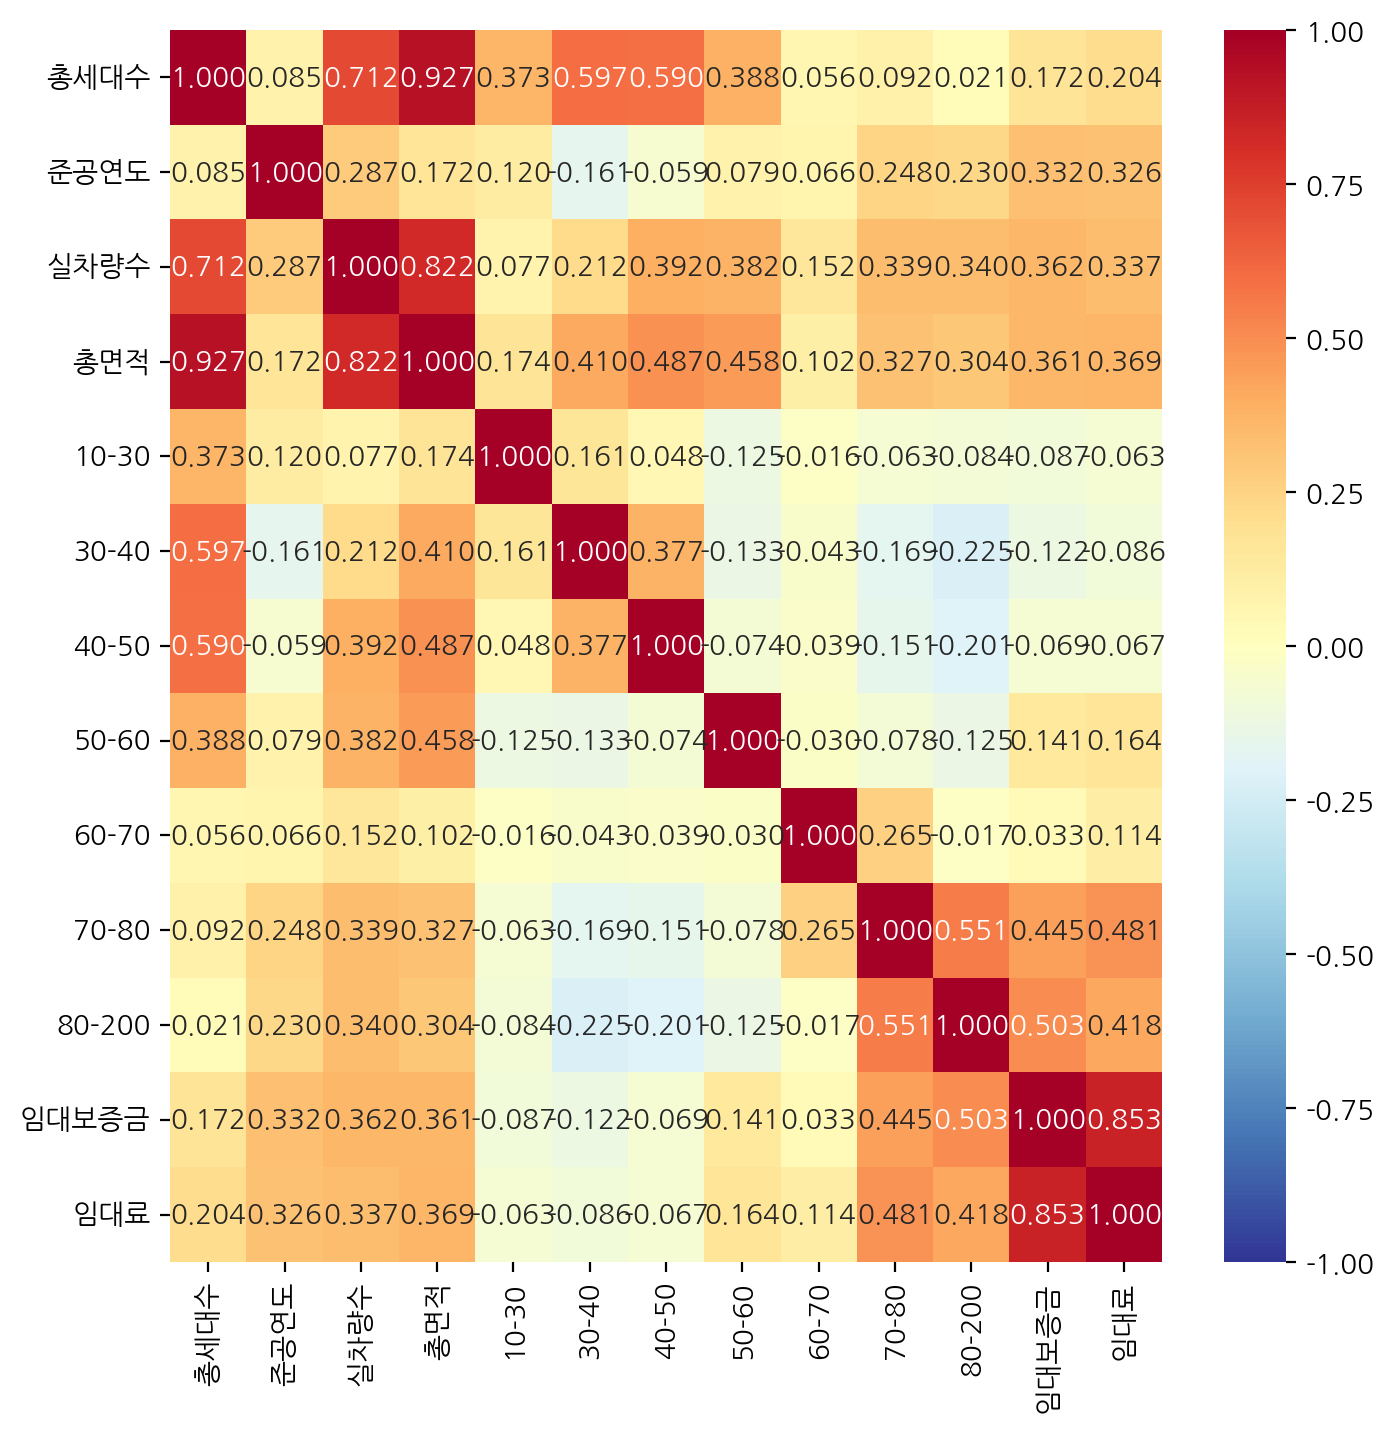

In [85]:
plt.figure(figsize = (8, 8))
sns.heatmap(base_data.corr(numeric_only=True), 
            annot = True,            # 숫자(상관계수) 표기 여부
            fmt = '.3f',             # 숫자 포멧 : 소수점 3자리까지 표기
            cmap = 'RdYlBu_r',       # 칼라맵
            vmin = -1, vmax = 1)     # 값의 최소, 최대값
plt.show()

In [93]:
base_data.groupby('지역')[['실차량수']].sum()

,실차량수
지역,
강원,4365
경기,53946
경남,7367
광주전남,29023
대구경북,27141
대전충남,12576
부산울산,24960
서울,25785
세종,1798


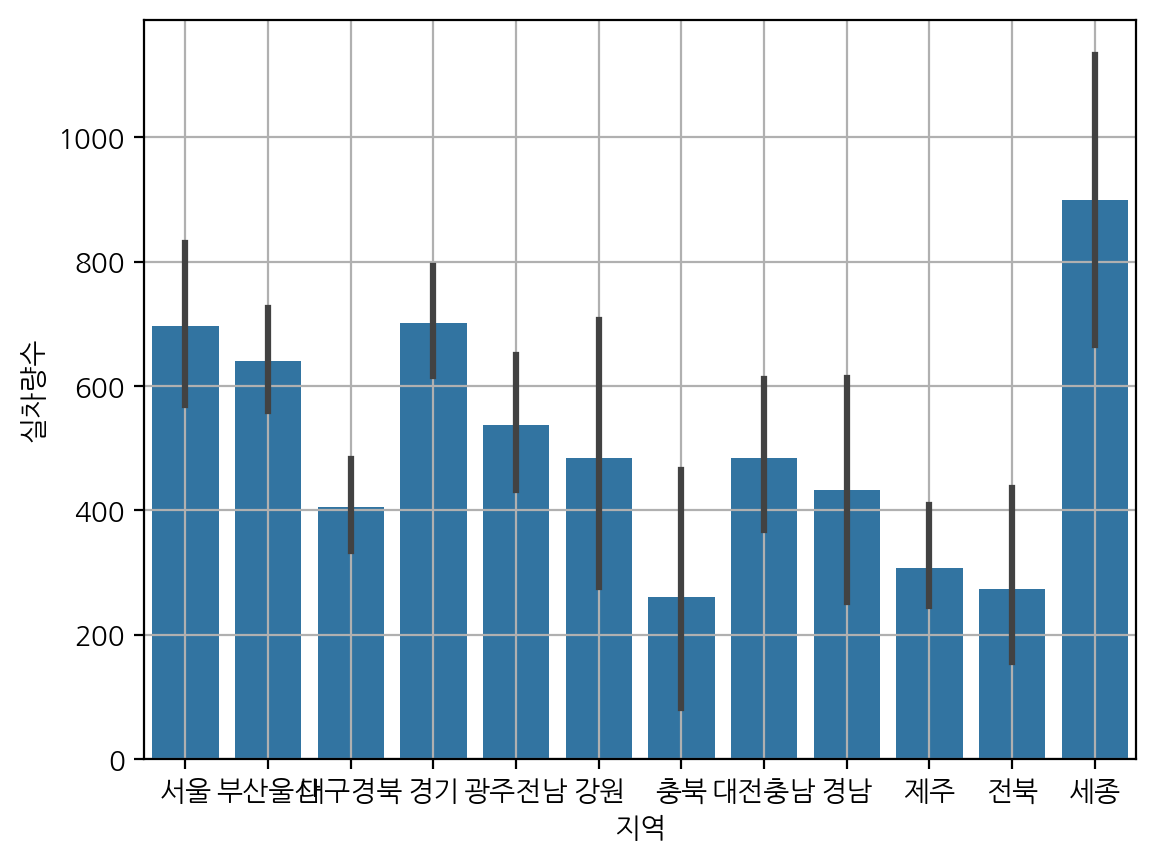

In [91]:
sns.barplot(x="지역", y="실차량수", data=base_data)
plt.grid()
plt.show()

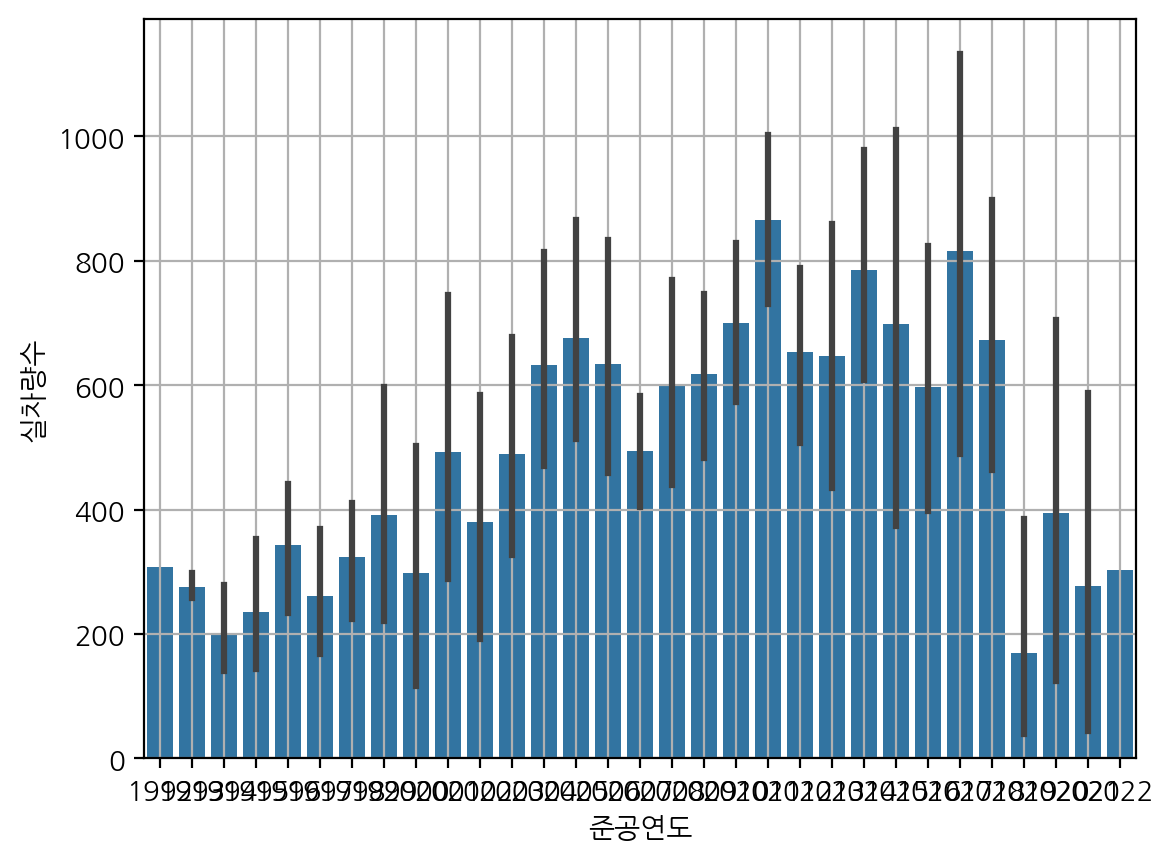

In [103]:
sns.barplot(x="준공연도", y="실차량수", data=base_data)
plt.grid()
plt.show()